In [1]:
# Copyright (c) 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the LICENSE file in
# the root directory of this source tree. An additional grant of patent rights
# can be found in the PATENTS file in the same directory.
"""
Translate pre-processed data with a trained model.
"""

import torch
import numpy as np
import math
import torch.nn.functional as F
import re

from fairseq import pybleu, options, progress_bar, tasks, tokenizer, utils, strategies
from fairseq.meters import TimeMeter
from fairseq.strategies.strategy_utils import duplicate_encoder_out
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
parser = options.get_generation_parser(interactive=False)
args = options.parse_args_and_arch(parser)

In [3]:
# args = setattr(args, "path", "output/my_maskPredict_en_ro/checkpoint37.pt")
# args = setattr(args, "task", "translation_self")
# args = setattr(args, "remove-bpe", True)
# args = setattr(args, "input", "output/data-bin")

In [4]:
def main(args):
    assert args.path is not None, '--path required for generation!'
    assert not args.sampling or args.nbest == args.beam, \
        '--sampling requires --nbest to be equal to --beam'
    assert args.replace_unk is None or args.raw_text, \
        '--replace-unk requires a raw text dataset (--raw-text)'

    if args.max_tokens is None and args.max_sentences is None:
        args.max_tokens = 12000
    print(args)

    use_cuda = torch.cuda.is_available() and not args.cpu
    torch.manual_seed(args.seed)

    # Load dataset splits
    task = tasks.setup_task(args)
    task.load_dataset(args.gen_subset)
    print('| {} {} {} examples'.format(args.data, args.gen_subset, len(task.dataset(args.gen_subset))))

    # Set dictionaries
    # src_dict = task.source_dictionary
    tgt_dict = task.target_dictionary
    dict = tgt_dict

    # Load decoding strategy
    strategy = strategies.setup_strategy(args)

    # Load ensemble
    print('| loading model(s) from {}'.format(args.path))
    models, _ = utils.load_ensemble_for_inference(args.path.split(':'), task,
                                                  model_arg_overrides=eval(args.model_overrides))
    models = [model.cuda() for model in models]
    # Optimize ensemble for generation
    for model in models:
#         model.make_generation_fast_(
#             beamable_mm_beam_size=None if args.no_beamable_mm else args.beam,
#             need_attn=args.print_alignment,
#         )
        if args.fp16:
            model.half()

    # Load alignment dictionary for unknown word replacement
    # (None if no unknown word replacement, empty if no path to align dictionary)
    align_dict = utils.load_align_dict(args.replace_unk)

    # Load dataset (possibly sharded)
    itr = task.get_batch_iterator(
        dataset=task.dataset(args.gen_subset),
        max_tokens=args.max_tokens,
        max_sentences=args.max_sentences,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            *[model.max_positions() for model in models]
        ),
        ignore_invalid_inputs=args.skip_invalid_size_inputs_valid_test,
        required_batch_size_multiple=8,
        num_shards=args.num_shards,
        shard_id=args.shard_id,
    ).next_epoch_itr(shuffle=False)

    with progress_bar.build_progress_bar(args, itr) as t:

        visualizate(t, models, tgt_dict, use_gold_target_len=args.gold_target_len)


def dehyphenate(sent):
    return re.sub(r'(\S)-(\S)', r'\1 ##AT##-##AT## \2', sent).replace('##AT##', '@')


def deduplicate(sent, dup_cnt):
    sent = sent.strip().split(" ")
    new_sent = [sent[0]]
    for i in range(1, len(sent)):
        if sent[i] != new_sent[-1]:
            new_sent.append(sent[i])
        else:
            dup_cnt += 1
    print("duplicated word number {}".format(dup_cnt))
    return " ".join(new_sent), dup_cnt


def visualizate(data_itr, models, tgt_dict, use_gold_target_len=False, cuda=True):
    """Iterate over a batched dataset and yield individual translations.
     Args:
        maxlen_a/b: generate sequences of maximum length ax + b,
                where x is the source sentence length.
            cuda: use GPU for generation
    """
    for sample in data_itr:
        s = utils.move_to_cuda(sample) if cuda else sample
        if 'net_input' not in s:
            continue
        input = s['net_input']
        if input['src_tokens'].size(1) < 15:
            continue

        # model.forward normally channels prev_output_tokens into the decoder
        # separately, but SequenceGenerator directly calls model.encoder
        encoder_input = {
            k: v for k, v in input.items()
            # if k != 'prev_output_tokens' and k != 'real_target'
        }

        with torch.no_grad():
            gold_target_len = s['target'].ne(tgt_dict.pad()).sum(-1) if use_gold_target_len else None
            hypos, gen_inner_state, gen_attention, dis_inner_state, dis_attention = generate(
                encoder_input, models)
            print(hypos.shape)
            print(len(gen_inner_state))
            print(gen_attention.shape)
            for batch in range(hypos.size(0)):
                src = utils.strip_pad(input['src_tokens'][batch].data, tgt_dict.pad())
                ref = utils.strip_pad(s['target'][batch].data, tgt_dict.pad()) if s['target'] is not None else None
                hypo = utils.strip_pad(hypos[batch], tgt_dict.pad())
                src_str = tgt_dict.string(src, args.remove_bpe)
                hypo_str = tgt_dict.string(hypo, args.remove_bpe)
                display_attention(src_str, hypo_str, gen_attention)
                display_attention(src_str, hypo_str, dis_attention)
        break


def generate(encoder_input, models):
    assert len(models) == 1
    model = models[0]
    model.eval()
    output = model(**encoder_input)
    # gen_dec_logits, dis_dec_logits, encoder_out['predicted_lengths'], fake_data, gen_decoder_out[1], dis_decoder_out[1]

    gen_inner_state, gen_attention = output[4]["inner_states"], output[4]["attn"]  # list
    dis_inner_state, dis_attention = output[5]["inner_states"], output[5]["attn"]  # list

    gen_out = output[0]
    probs = F.softmax(gen_out, dim=-1)
    max_probs, hypotheses = probs.max(dim=-1)
    return hypotheses, gen_inner_state, gen_attention, dis_inner_state, dis_attention


def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):
    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(15, 25))

    #for i in range(n_heads):
    ax = fig.add_subplot(n_rows, n_cols, 1)

    #_attention = attention.squeeze(0)[i].cpu().detach().numpy()
    _attention = attention.squeeze(0).cpu().detach().numpy()
    cax = ax.matshow(_attention, cmap='bone')

    ax.tick_params(labelsize=12)
    ax.set_xticklabels(sentence.split(), rotation=45)
    ax.set_yticklabels(translation.split())

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Namespace(beam=5, cpu=False, criterion='cross_entropy', data=['output/data-bin'], dataset_impl=None, decoding_iterations=None, decoding_strategy='left_to_right', dehyphenate=False, diverse_beam_groups=-1, diverse_beam_strength=0.5, dynamic_length=False, fff='/root/.local/share/jupyter/runtime/kernel-a7a997c4-4a11-4028-b579-419782c74661.json', force_anneal=None, fp16=False, fp16_init_scale=128, fp16_scale_tolerance=0.0, fp16_scale_window=None, gen_subset='test', gold_target_len=False, left_pad_source='True', left_pad_target='False', length_beam=5, lenpen=1, log_format=None, log_interval=1000, lr_scheduler='fixed', lr_shrink=0.1, mask_range=False, match_source_len=False, max_len_a=0, max_len_b=200, max_sentences=1, max_source_positions=1024, max_target_positions=1024, max_tokens=None, memory_efficient_fp16=False, min_len=1, min_loss_scale=0.0001, model_overrides='{}', momentum=0.99, nbest=1, no_beamable_mm=False, no_early_stop=False, no_progress_bar=False, no_repeat_ngram_size=0, num_sha

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: utils.load_ensemble_for_inference is deprecated. Please use checkpoint_utils.load_model_ensemble instead.


Model setting Right here!
torch.Size([1, 9])
7
torch.Size([1, 9, 15])


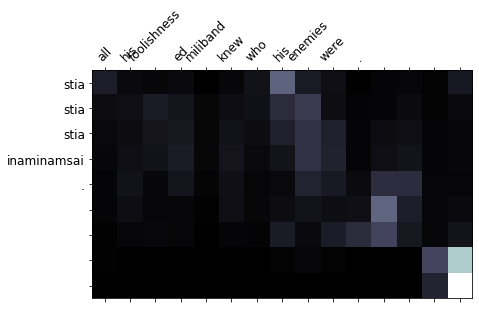

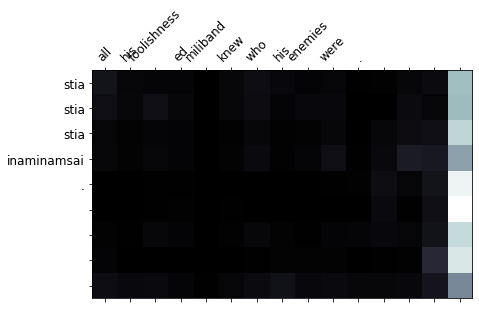

In [5]:
main(args)